<a href="https://colab.research.google.com/github/snehanshu-raj/EVA7/blob/main/pytorch_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Download Dataset

In [3]:
train_set = torchvision.datasets.MNIST(
    root = './data', # store in data folder(create data folder)
    train = True,    # use the train folder from the dataset
    download = True, # download if it is not found
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Preparing the Data

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_set, #from where our data is coming
    batch_size = 32,
    shuffle = True
)
# we want to look for multiple images and send batch of images to our model

# General Visualisation
Getting familiar with our data.

In [5]:
batch = next(iter(train_loader))

In [6]:
images, labels = batch   # Dividing batch into images and labels
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

lables:  tensor([9, 0, 6, 8, 1, 2, 2, 1, 2, 1, 7, 9, 0, 7, 0, 8, 9, 0, 9, 1, 8, 9, 7, 9,
        8, 7, 5, 6, 7, 2, 2, 6])


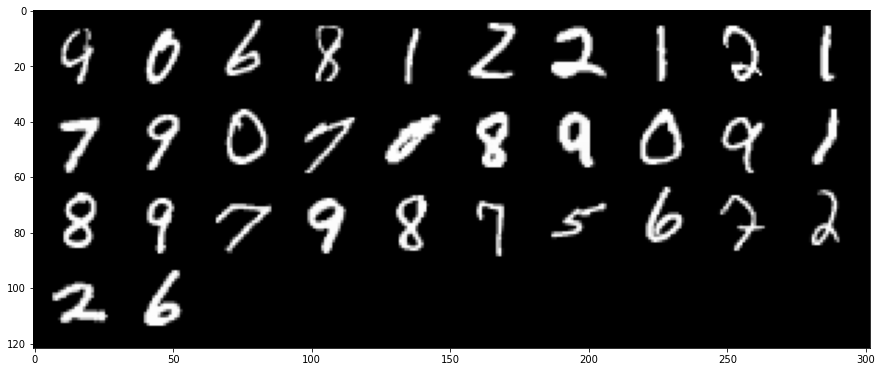

In [7]:
import matplotlib.pyplot as plt
import numpy as np

grid = torchvision.utils.make_grid(images, nrow=10)  # creating a grid to view the images in the batch
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('lables: ', labels)

# Create Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class Network(nn.Module): # allows us to use features present inside Module
  def __init__(self):
    super().__init__()

    # input 1x28x28, output 1x26x26, receptive_field=3*3
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)  # Convolution layer 1

    # input 1x26x26
    self.fc1 = nn.Linear(in_features=1*13*13, out_features=100)   # Fully Connected Layer1

    self.out = nn.Linear(in_features=100, out_features=10)    # Output Layer

  def forward(self, random_number, MNIST_number): # forward function present in the Module, for back propagation etc
    
    # input layer
    x = MNIST_number
    y = random_number
    
    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x) # Passing the convolution layer through the Relu activation function
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 26 | 13. Performing Max pooling which will reduce the image size by half and double the RF

    # reshaping to flatten the data for the Fully Connected Layer to begin processing
    x = x.reshape(-1, 1*13*13)

    # fc1 layer
    x = self.fc1(x) 
    x = F.relu(x) # Passing the FC layer thru the Relu activation function

    # output layer
    x = self.out(x)
    x = F.softmax(x, dim=1) 
    # we never add activation function at the last layer

    prediction = x
    return prediction, prediction.argmax(dim=1) + y   # we are creating 2 outputs:- 1)image's predicted value 2)the addition of the random number and the predicted value

In [36]:
torch.set_grad_enabled(False)  # we havent begun training yet, hence we can turn off Pytorch's gradient calculations to reduce memory consumption

Getting an image from training set and viewing it.

label:  5


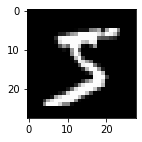

In [37]:
sample = next(iter(train_set)) # generating an image from the train set
image, label = sample  # dividing the sample into images and labels

# printing the image
grid = torchvision.utils.make_grid(image, nrow=1)
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(grid, (1,2,0)))
print('label: ', label)

Passing a random number and the image to be predicted to our network.

In [38]:
import random    # generating the random number using the random function in Python
random_int = random.randint(0, 10)

network = Network()   # Creating an instance of the network class

pred, ans = network(random_int, image.unsqueeze(0))   # passing the random number and the image to the network. This will provide us with the 2 outputs

print(
    'Predicted number: ', pred.argmax(dim=1).item(),
    '\nActual number: ', label,
    '\n\nPrediction: ', pred.argmax(dim=1).eq(label).item(),
    '\n\nRandom int generated: ', random_int,
    '\n\nSum by network: ', ans.item(),
    '\nActual Sum: ', label + random_int
)

Predicted number:  9 
Actual number:  5 

Prediction:  False 

Random int generated:  10 

Sum by network:  19 
Actual Sum:  15


# Let's begin Training!

In [39]:
import torch.optim as optim

In [40]:
torch.set_grad_enabled(True)  # Turning the gradient calculation on since we are training now

Create a training set of batch of 10 images.

lables:  tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


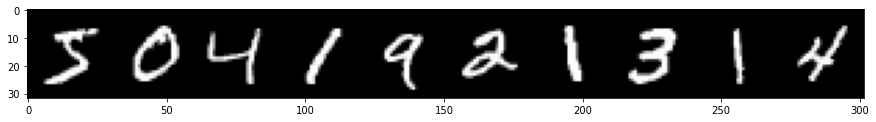

In [41]:
network = Network()  # creating an instance of the Network class

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)  # creating the train_loader dataset batch of 10 images from train_set
for batch in train_loader:
  images, label = batch   # dividing batch into images and labels
  grid = torchvision.utils.make_grid(images, nrow=10)  # creating a grid to view the images
  plt.figure(figsize=(15,15))  # providing the size of each iamge to be printed
  plt.imshow(np.transpose(grid, (1,2,0)))
  print('lables: ', label)  # printing the labels present in the batch
  break

Function to calculate the correct predictions by the netwrok.

In [42]:
def get_num_correct(preds, labels):  # creating a function to get correct number of predictions
  return preds.argmax(dim=1).eq(labels).sum().item() # returning the output which will show how many predicitons are equal to our labels (actual)

Trial testing when image is being sent in proper batches and not fake batch, along with list of random integers.

In [43]:
network = Network()  # creating an instance of the network class

batch = next(iter(train_loader))  # creating the batch from an iteration of the train_loader 
images, labels = batch            # dividing batch into images and labels

randomlist = []                   # creating a list of random numbers generated using the 'Random' function in Python
for i in range(10):
  n = random.randint(0, 9)
  randomlist.append(n)

randomlist = torch.as_tensor(randomlist)  # converting the python list into a tensor

preds, ans = network(randomlist.unsqueeze(0).unsqueeze(0), images)  # passing the tensor(random list) and the images from the batch to the network
correct = get_num_correct(preds, labels)  # calling the function 'get_num_correct' and storing the value in the 'correct' variable

print('random list:', '\t\t', randomlist.numpy())
print('prediction values:', '\t', preds.argmax(dim=1).numpy())
print('actual values:', '\t\t', labels.numpy())
print('sums:', '\t\t\t', ans.squeeze().numpy())
print('corrects:', correct)

random list: 		 [4 4 5 1 4 7 1 0 0 0]
prediction values: 	 [2 2 6 2 2 2 2 2 2 2]
actual values: 		 [5 0 4 1 9 2 1 3 1 4]
sums: 			 [ 6  6 11  3  6  9  3  2  2  2]
corrects: 1


# Training

In [ ]:
torch.cuda.is_available()  # checking if CUDA is available

True

In [44]:
optimizer = optim.Adam(network.parameters(), lr=0.01) # optimizer decides how do we update our weights

for epoch in range(10):
  total_loss = 0
  total_correct = 0

  for batch in train_loader:
    images, labels = batch

    randomlist = []
    for i in range(10):
      n = random.randint(0, 9)
      randomlist.append(n)

    randomlist = torch.as_tensor(randomlist)

    preds, ans = network(randomlist, images)
    loss = F.cross_entropy(preds, labels)  # Loss function

    optimizer.zero_grad() # before we do back propogation, we need to make grad value 0
    loss.backward()
    optimizer.step() # update the weights

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

  print(
      "epoch: ", epoch,
      "total_correct: ", total_correct,
      "loss: ", total_loss
  )

epoch:  0 total_correct:  48547 loss:  9910.356339335442
epoch:  1 total_correct:  51589 loss:  9606.443757295609
epoch:  2 total_correct:  51466 loss:  9619.786152243614
epoch:  3 total_correct:  51317 loss:  9634.464397192001
epoch:  4 total_correct:  51159 loss:  9650.727604746819
epoch:  5 total_correct:  51359 loss:  9630.880885243416
epoch:  6 total_correct:  51427 loss:  9624.400398492813
epoch:  7 total_correct:  50460 loss:  9721.007917404175
epoch:  8 total_correct:  51421 loss:  9624.77878499031
epoch:  9 total_correct:  50968 loss:  9670.008599281311
